# CIFAR-10 Image Classification

## Table of Contents
- [Introduction](#introduction)
- [Import the dataset](#import-the-dataset)
- [Investigate and preprocess the dataset](#investigate-and-preprocess-the-dataset)
- [Evaluating model performance](#evaluating-model-performance)
- [Build a simple neural network](#build-a-simple-neural-network)

## Introduction <a class="anchor" id="introduction"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

## Import the dataset <a class="anchor" id="import-the-dataset"></a>

Import the CIFAR-10 dataset from Keras using the load_data function and one-hot encode the labels

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Investigate and preprocess the dataset <a class="anchor" id="investigate-and-preprocess-the-dataset"></a>

Investigate the properties of the training and test data

In [3]:
print(f"Number of training data rows: {x_train.shape[0]}")
print(f"Number of test data rows: {x_test.shape[0]}")
print(f'Resolution of each image: {x_train.shape[1]} x {x_train.shape[2]}')
print(f'Number of channels: {x_train.shape[3]}')
print(f'Number of classes: {len(np.unique(y_train))}')

Number of training data rows: 50000
Number of test data rows: 10000
Resolution of each image: 32 x 32
Number of channels: 3
Number of classes: 2


We can see that there are 50,000 training images and 10,000 test images meaning that the dataset is split into ~83% training and ~17% test data. Each image is 32x32 pixels with 3 channels (RGB).

In order to effectively compare the models, we need to create a validation set. In this case, we will take 20% of the training set as the validation set and use stratification to ensure that the classes are evenly distributed between the training and validation sets.

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

Display an image corresponding to each of the 10 classes using matplotlib

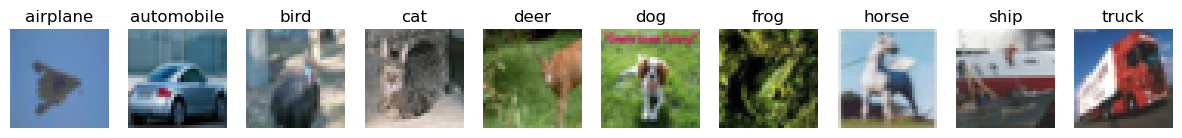

In [5]:
target_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

figure, axis = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(len(target_names)):
    index = np.argmax(y_train, axis=1) == i
    index = np.argmax(index)
    axis[i].imshow(x_train[index])
    axis[i].set_title(target_names[i])
    axis[i].axis('off')
plt.show()

As the images use the RGB colour model, the pixel values for each image are positive integers in the range of [0,255]. Therefore, we need to normalise the pixel values into the range of [0,1].

In [6]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

## Evaluating model performance <a class="anchor" id="evaluating-model-performance"></a>

Create a function to display the accuracy and loss of the model over the training and validation sets

In [7]:
def plot_training_accuracy_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')

    plt.show()

Create a function to display the confusion matrix of the model

In [8]:
def confusion_matrix(model):
    predictions = model.predict(x_test)
    predictions = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    cm = tf.math.confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

Create a function to calculate the accuracy and loss of the model on the test set

In [9]:
def test_model(model):
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')
    # Create a confusion matrix
    confusion_matrix(model)

## Build a simple neural network <a class="anchor" id="simple-neural-network"></a>

Create a simple neural network consisting of a single fully connected layer as a baseline:

- The first layer is a convolutional layer with 32 filters, a kernel size of 3x3. The input shape is 32x32x3 (the 3 corresponds to the 3 channels in the RGB colour model).
- This 1D array is passed to a single fully connected layer with 10 neurons and a softmax activation function, where each neuron corresponds to a class.
- The output of the softmax activation function is a probability distribution over the 10 classes in the CIFAR-10 dataset.
- The categorical cross-entropy loss function (as the labels are one-hot encoded and this is a good choice according to [the documentation](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class))

Start by using:
- ReLU activation function (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

In [224]:
single_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(10, activation='softmax')
])
single_layer_model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy']
                           )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

In [225]:
single_layer_model_history = single_layer_model.fit(x_train, y_train, batch_size=128, epochs=100,
                                                    validation_data=(x_val, y_val))

Epoch 1/100
313/313 [==============================] - 1s 4ms/step - loss: 1.5678 - accuracy: 0.4492 - val_loss: 1.3831 - val_accuracy: 0.4995
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 1.2616 - accuracy: 0.5610 - val_loss: 1.2636 - val_accuracy: 0.5512
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1578 - accuracy: 0.5996 - val_loss: 1.2179 - val_accuracy: 0.5730
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 1.0819 - accuracy: 0.6271 - val_loss: 1.1834 - val_accuracy: 0.5847
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 1.0264 - accuracy: 0.6472 - val_loss: 1.1965 - val_accuracy: 0.5831
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9735 - accuracy: 0.6673 - val_loss: 1.1567 - val_accuracy: 0.5947
Epoch 7/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9191 - accuracy: 0.6858 - val_loss: 1.1674 - val_accuracy: 0.5987

Evaluate the model by plotting the accuracy and loss over the training and validation sets

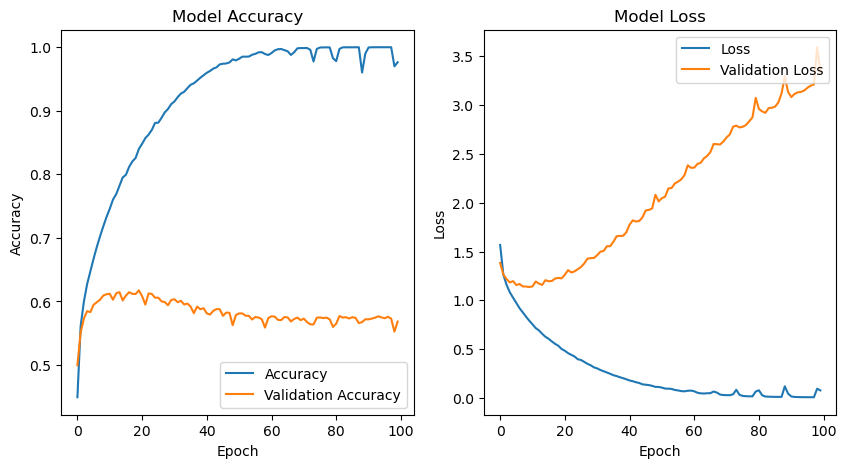

In [226]:
plot_training_accuracy_loss(single_layer_model_history)

Run the model on the test set and display the confusion matrix

Test accuracy: 0.5705999732017517
Test loss: 3.373800754547119
313/313 [==============================] - 0s 930us/step


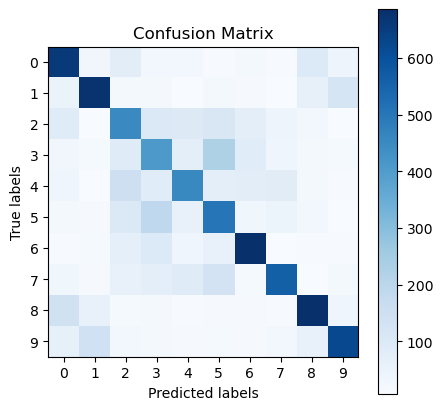

In [227]:
test_model(single_layer_model)

It is clear that the model is overfitting the training data because the validation loss begins to increase after about 10 epochs and the training accuracy approaches 1.0. Later, regularisation techniques will be explored on a deep convolutional neural network to reduce overfitting. First, lets compare the performance of the model with different activation functions, and do an early stop after 20 epochs to reduce overfitting.

### Compare with different activation functions

In order to compare the performance of the model with different activation functions, we will create a model for each activation function and train it for 100 epochs. Then, the validation accuracy will be plotted for each model so that they can be compared.

In [102]:
# Create a list of activation functions to compare
activation_functions = ['relu', 'sigmoid', 'tanh']

# Create a model for each activation function and train it for 100 epochs, then plot the validation accuracy
for activation in activation_functions:
    model = Sequential([
        Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0)
    plt.plot(history.history['val_accuracy'], label=activation)
    print(f'Train accuracy for {activation} activation function: {model.evaluate(x_train, y_train, verbose=0)[1]}')
    print(f'Validation accuracy for {activation} activation function: {model.evaluate(x_val, y_val, verbose=0)[1]}')
    print(f'Test accuracy for {activation} activation function: {model.evaluate(x_test, y_test, verbose=0)[1]}')

plt.title('Comparison of Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

The graph shows that the ReLU activation function performs better than the sigmoid and tanh activation functions as the validation accuracy is much higher across all epochs. ReLU is generally considered to be better than sigmoid and tanh for image classification as it's computationally efficient and avoids the vanishing gradient problem, although it will be worth performing this comparison on another models to see if ReLU is consistently the better performing activation function.

### Compare with different optimisers

Epoch 1/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5230 - accuracy: 0.4630 - val_loss: 1.3453 - val_accuracy: 0.5349
Epoch 2/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2121 - accuracy: 0.5796 - val_loss: 1.3272 - val_accuracy: 0.5412
Epoch 3/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.0764 - accuracy: 0.6288 - val_loss: 1.2024 - val_accuracy: 0.5859
Epoch 4/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.9675 - accuracy: 0.6675 - val_loss: 1.2045 - val_accuracy: 0.5925
Epoch 5/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8843 - accuracy: 0.6956 - val_loss: 1.2209 - val_accuracy: 0.5940
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8068 - accuracy: 0.7234 - val_loss: 1.2592 - val_accuracy: 0.5875
Epoch 7/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.7446 - accuracy: 0.7476 - val_loss: 1.2582 - val_accuracy:

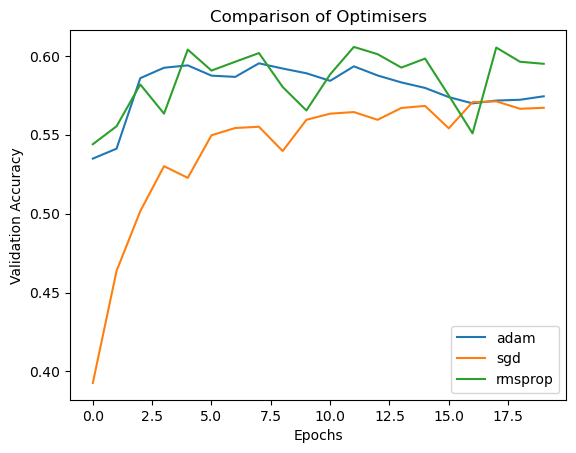

In [38]:
optimisers = ['adam', 'sgd', 'rmsprop']

for optimiser in optimisers:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
    plt.plot(history.history['val_accuracy'], label=optimiser)

plt.title('Comparison of Optimisers')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

This graph shows that the performance of the model is relatively similar for Adam and RMSprop, with SGD being slightly lower. Throughout the training, both Adam and RMSprop perform better than the other at some point, but the differences are not significant after the first few epochs. Therefore, the Adam optimiser will continue to be used for the rest of the comparisons with this model, although it will be worth performing this comparison on other models to see which optimiser is consistently the best.

### Compare with different learning rates

Epoch 1/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7765 - accuracy: 0.3775 - val_loss: 1.6379 - val_accuracy: 0.4231
Epoch 2/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5421 - accuracy: 0.4663 - val_loss: 1.5007 - val_accuracy: 0.4783
Epoch 3/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4347 - accuracy: 0.5038 - val_loss: 1.4290 - val_accuracy: 0.4985
Epoch 4/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.3591 - accuracy: 0.5324 - val_loss: 1.3813 - val_accuracy: 0.5146
Epoch 5/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2999 - accuracy: 0.5545 - val_loss: 1.3513 - val_accuracy: 0.5234
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2543 - accuracy: 0.5688 - val_loss: 1.3142 - val_accuracy: 0.5436
Epoch 7/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2171 - accuracy: 0.5848 - val_loss: 1.2997 - val_accuracy:

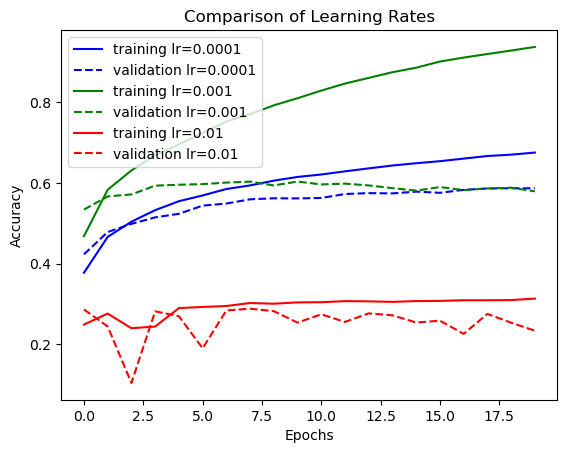

In [97]:
learning_rates = [0.0001, 0.001, 0.01]
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, learning_rate in enumerate(learning_rates):
    colour = colours[i % len(colours)]
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
    plt.plot(history.history['accuracy'], label=f'training lr={learning_rate}', color=colour)
    plt.plot(history.history['val_accuracy'], label=f'validation lr={learning_rate}', color=colour, linestyle='--')

plt.title('Comparison of Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From this graph, we can see that a learning rate of between 0.0001 and 0.001 is the best performing because the validation accuracy for these learning rates are similar, being much higher than 0.01 which performs extremely poorly. However, a learning rate closer to 0.001 may be prone to overfitting as the training accuracy is much higher than the validation accuracy, although it will be interesting to test this with another model architecture.

## Build a more complex neural network

Create a more complex neural network consisting of 3 convolutional layers with max pooling layers between them, followed by a flatten layer and 2 dense layers.

Model architecture: *TensorFlow. Convolutional Neural Networks (CNN) - TensorFlow Core. [online] Available at: https://www.tensorflow.org/tutorials/images/cnn [Accessed 6 March 2023]*.

- The first convolutional layer has 32 filters of size 3x3, whereas the second and third convolutional layers have 64 filters of size 3x3.
- The max pooling layers inbetween each convolutional layer has a pool size of 2x2.
- The output of the final convolutional layer is flattened and passed to a dense layer with 64 neurons.
- The final dense layer has 10 neurons and a softmax activation function, where each neuron corresponds to a class.

Again, start by using:
- ReLU activation function for the convolutional layers (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

In [230]:
multi_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
                          )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

Epoch 1/100
625/625 [==============================] - 3s 4ms/step - loss: 1.6278 - accuracy: 0.4031 - val_loss: 1.4082 - val_accuracy: 0.4965
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 1.2581 - accuracy: 0.5490 - val_loss: 1.3647 - val_accuracy: 0.5235
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 1.1045 - accuracy: 0.6105 - val_loss: 1.0558 - val_accuracy: 0.6259
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.9948 - accuracy: 0.6525 - val_loss: 0.9968 - val_accuracy: 0.6475
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.9167 - accuracy: 0.6801 - val_loss: 0.9435 - val_accuracy: 0.6704
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8568 - accuracy: 0.6997 - val_loss: 0.9801 - val_accuracy: 0.6599
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8119 - accuracy: 0.7179 - val_loss: 0.9090 - val_accuracy: 0.6833

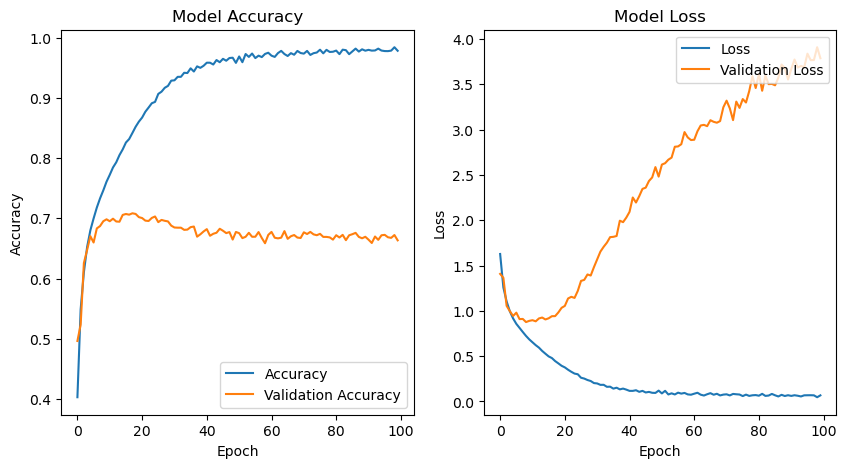

In [231]:
multi_layer_model_history = multi_layer_model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))
plot_training_accuracy_loss(multi_layer_model_history)

Test accuracy: 0.6568999886512756
Test loss: 3.8322043418884277
313/313 [==============================] - 0s 1ms/step


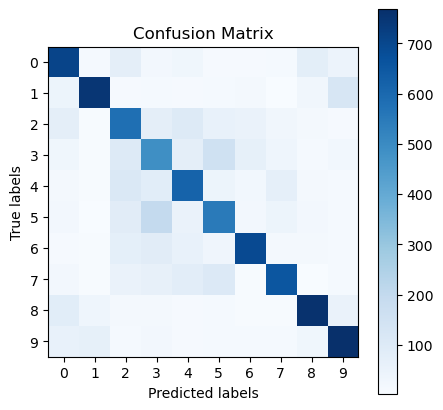

In [232]:
test_model(multi_layer_model)

As expected, this model performs much better than the single layer model, as evidenced by greater test accuracy. However, similar to the single layer model, the model is overfitting the training data. As a result, we will also do an early stop after 20 epochs to prevent the model from overfitting.

### Compare different activation functions

For this model, all the layers that use an activation function will be modified, except the final layer which must remain as softmax. The activation functions to compare are:
- ReLU
- Sigmoid
- Tanh

In [100]:
# Create a list of activation functions to compare
activation_functions = ['relu', 'sigmoid', 'tanh']

# Create a model for each activation function and train it for 100 epochs, then plot the validation accuracy
for activation in activation_functions:
    model = Sequential([
        Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation),
        Flatten(),
        Dense(64, activation=activation),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0)
    plt.plot(history.history['val_accuracy'], label=activation)
    print(f'Train accuracy for {activation} activation function: {model.evaluate(x_train, y_train, verbose=0)[1]}')
    print(f'Validation accuracy for {activation} activation function: {model.evaluate(x_val, y_val, verbose=0)[1]}')
    print(f'Test accuracy for {activation} activation function: {model.evaluate(x_test, y_test, verbose=0)[1]}')

plt.title('Comparison of Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Similar to the simple model, ReLU is the best performing activation function

### Compare with different optimisers

Epoch 1/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5592 - accuracy: 0.4302 - val_loss: 1.2796 - val_accuracy: 0.5418
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.1855 - accuracy: 0.5785 - val_loss: 1.1100 - val_accuracy: 0.6113
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0331 - accuracy: 0.6357 - val_loss: 1.0529 - val_accuracy: 0.6284
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9266 - accuracy: 0.6748 - val_loss: 1.0110 - val_accuracy: 0.6390
Epoch 5/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8535 - accuracy: 0.7037 - val_loss: 0.9415 - val_accuracy: 0.6726
Epoch 6/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7948 - accuracy: 0.7226 - val_loss: 0.9121 - val_accuracy: 0.6753
Epoch 7/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7407 - accuracy: 0.7414 - val_loss: 0.8985 - val_accuracy:

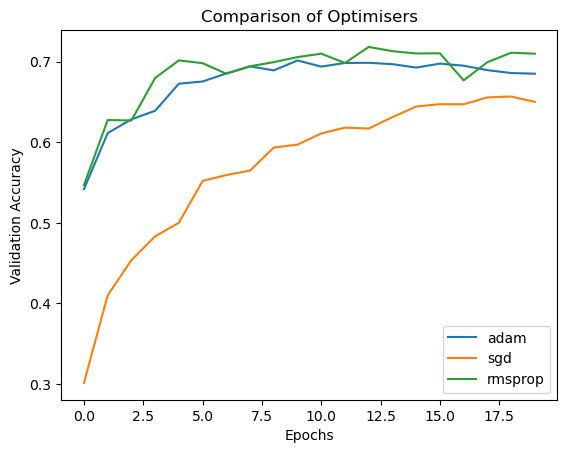

In [44]:
# Create a list of optimisers to compare
optimisers = ['adam', 'sgd', 'rmsprop']

# Create a model for each optimiser and train it for 100 epochs, then plot the validation accuracy
for optimiser in optimisers:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
    plt.plot(history.history['val_accuracy'], label=optimiser)

plt.title('Comparison of Optimisers')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

Similar to the simple model, both the Adam and RMSProp optimisers perform better than the SGD optimiser. This could be because Adam and RMSProp are adaptive optimisers meaning that they adapt the learning rate during training, whereas SGD does not. Since both Adam and RMSProp offer similar results, we will use Adam for the rest of the experiments.

### Compare with different learning rates

Epoch 1/20
1250/1250 [==============================] - 5s 3ms/step - loss: 1.8551 - accuracy: 0.3212 - val_loss: 1.5965 - val_accuracy: 0.4152
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5181 - accuracy: 0.4546 - val_loss: 1.4683 - val_accuracy: 0.4702
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4254 - accuracy: 0.4892 - val_loss: 1.4155 - val_accuracy: 0.4906
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3631 - accuracy: 0.5138 - val_loss: 1.3547 - val_accuracy: 0.5128
Epoch 5/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3111 - accuracy: 0.5367 - val_loss: 1.3148 - val_accuracy: 0.5349
Epoch 6/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2664 - accuracy: 0.5536 - val_loss: 1.2592 - val_accuracy: 0.5543
Epoch 7/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2235 - accuracy: 0.5704 - val_loss: 1.2198 - val_accuracy:

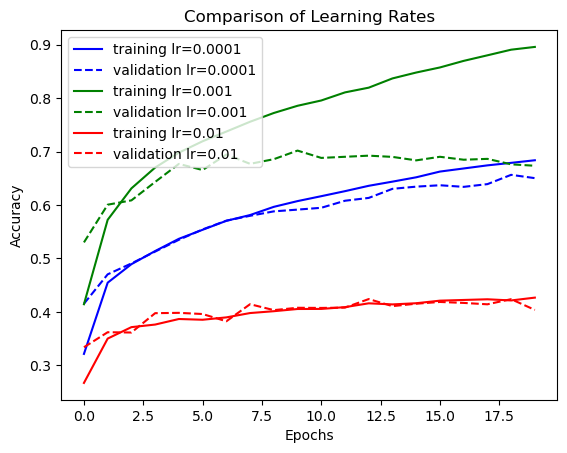

In [93]:
learning_rates = [0.0001, 0.001, 0.01]

for i, learning_rate in enumerate(learning_rates):
    colour = colours[i % len(colours)]
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
    plt.plot(history.history['accuracy'], label=f'training lr={learning_rate}', color=colour)
    plt.plot(history.history['val_accuracy'], label=f'validation lr={learning_rate}', color=colour, linestyle='--')

plt.title('Comparison of Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The results seen with different learning rates on this model are similar to the results seen with the simple model - learning rates of 0.0001 and 0.001 have similar performance on the validation set by the 20th epoch, while the learning rate of 0.01 has much worse performance. This is likely due to the fact that the learning rate is too high, and the model is unable to converge to a good solution. Also similar to the simple model, a learning rate of 0.001 may overfit on the training set as the training accuracy is much higher than the validation accuracy.

### Compare with different filter sizes and number of filters

For this model, we will compare the performance of different filter sizes. The filter sizes to compare are:
- 3x3
- 5x5
- 7x7

We need to add padding to each convolutional layer to allow the larger filters to slide over the edges of images.

Epoch 1/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4960 - accuracy: 0.4572 - val_loss: 1.1851 - val_accuracy: 0.5732
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0865 - accuracy: 0.6148 - val_loss: 1.0161 - val_accuracy: 0.6392
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9031 - accuracy: 0.6818 - val_loss: 0.9330 - val_accuracy: 0.6846
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7797 - accuracy: 0.7267 - val_loss: 0.9498 - val_accuracy: 0.6683
Epoch 5/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6912 - accuracy: 0.7556 - val_loss: 0.8731 - val_accuracy: 0.6940
Epoch 6/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6143 - accuracy: 0.7847 - val_loss: 0.8721 - val_accuracy: 0.7098
Epoch 7/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5487 - accuracy: 0.8085 - val_loss: 0.8724 - val_accuracy:

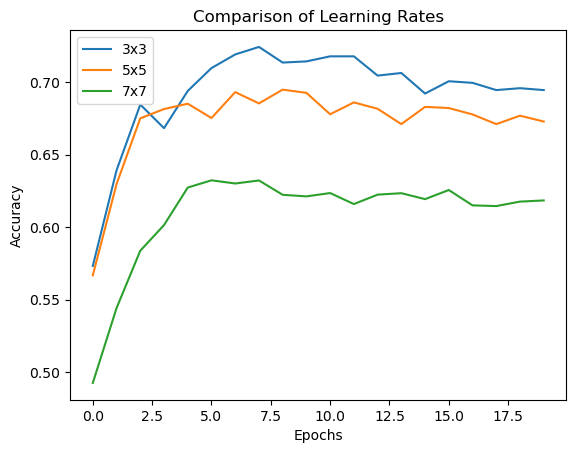

In [61]:
filter_sizes = [3, 5, 7]

for filter_size in filter_sizes:
    model = Sequential([
        Conv2D(32, (filter_size, filter_size), activation='relu', padding='same', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (filter_size, filter_size), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (filter_size, filter_size), activation='relu', padding='same'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
    plt.plot(history.history['val_accuracy'], label=f'{filter_size}x{filter_size}')

plt.title('Comparison of Filter Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

These results show that 3x3 filters produce the best results. This is likely because the 3x3 filters are able to capture more local information than the larger filters, which are better at observing global patterns.

We will now compare the performance of different numbers of filters. The numbers of filters to compare are:
- 32
- 64
- 128
- Increasing the number of filters in each layer 32 -> 64 -> 128

Epoch 1/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6455 - accuracy: 0.3983 - val_loss: 1.4045 - val_accuracy: 0.4845
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3123 - accuracy: 0.5287 - val_loss: 1.2453 - val_accuracy: 0.5586
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.1778 - accuracy: 0.5822 - val_loss: 1.1491 - val_accuracy: 0.5878
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0785 - accuracy: 0.6200 - val_loss: 1.0578 - val_accuracy: 0.6274
Epoch 5/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0172 - accuracy: 0.6409 - val_loss: 1.0204 - val_accuracy: 0.6372
Epoch 6/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9619 - accuracy: 0.6621 - val_loss: 1.0062 - val_accuracy: 0.6475
Epoch 7/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9124 - accuracy: 0.6781 - val_loss: 0.9950 - val_accuracy:

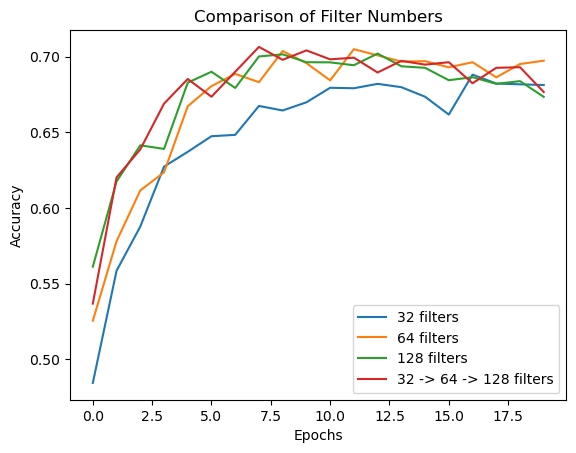

In [91]:
filter_numbers = [32, 64, 128]

for filter_number in filter_numbers:
    model = Sequential([
        Conv2D(filter_number, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(filter_number, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(filter_number, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
    plt.plot(history.history['val_accuracy'], label=f'{filter_number} filters')

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
plt.plot(history.history['val_accuracy'], label='32 -> 64 -> 128 filters')

plt.title('Comparison of Filter Numbers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

These results show that increasing the number of filters in each layer does not have much effect on the performance of the model which is likely because the model is able to learn the features it needs with 32 filters.

### Use discovered hyperparameters to train a model

Using the results from the previous experiments, we will now create the multi-layer model with the following configuration:
- activation function: ReLU
- optimiser: Adam
- learning rate: 0.0001
- filter size: 3x3
- filter numbers: 32

Since this is fairly similar to the initial multi-layer model configuration, effectively we will be testing the difference in learning rate on the multi-layer model. For consistency, it will be trained for 100 epochs.

In [94]:
multi_layer_model_tuned = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy']
                          )

Epoch 1/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9265 - accuracy: 0.2950 - val_loss: 1.6895 - val_accuracy: 0.3819
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6232 - accuracy: 0.4094 - val_loss: 1.5600 - val_accuracy: 0.4354
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5219 - accuracy: 0.4522 - val_loss: 1.4786 - val_accuracy: 0.4623
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4515 - accuracy: 0.4787 - val_loss: 1.4466 - val_accuracy: 0.4720
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4033 - accuracy: 0.4983 - val_loss: 1.3920 - val_accuracy: 0.4979
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3648 - accuracy: 0.5105 - val_loss: 1.3650 - val_accuracy: 0.5045
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3377 - accuracy: 0.5255 - val_loss: 1.3514 - val_ac

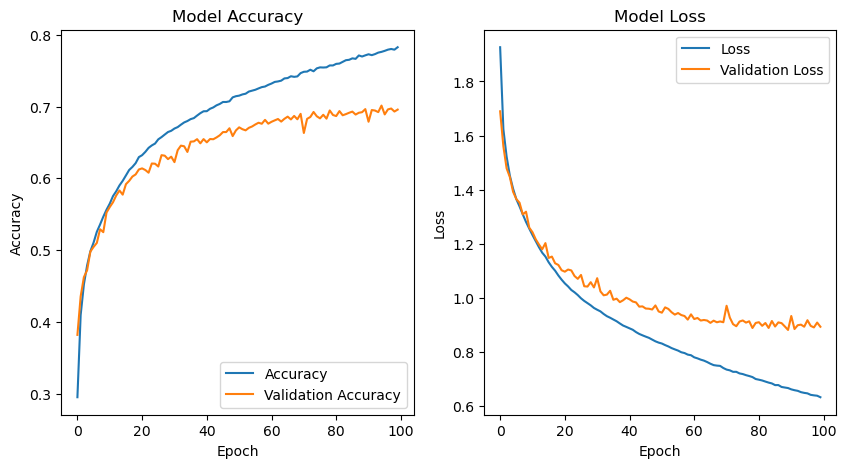

In [95]:
multi_layer_model_tuned_history = multi_layer_model_tuned.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))
plot_training_accuracy_loss(multi_layer_model_tuned_history)

Test accuracy: 0.6966000199317932
Test loss: 0.893698513507843
313/313 [==============================] - 0s 1ms/step


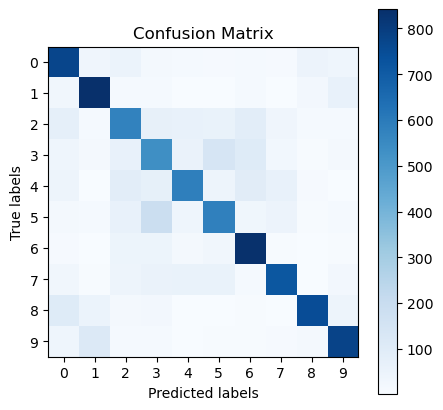

In [96]:
test_model(multi_layer_model_tuned)

It is clear to see that using a learning rate of 0.0001 has improved the performance of the model as the test accuracy has increased by approximately 4% compared to the initial model. This is likely due to the fact that the learning rate is lower, and the model is able to converge to a better solution. It is also clear that the amount the model overfits on the training set has decreased as the training accuracy is now closer to the validation accuracy and the validation loss is lower.

## Build a Deep Convolutional Neural Network with VGG architecture

Since we've built a simple CNN and a more complex CNN, let's now experiment building a deep CNN using the VGG architecture which is a popular architecture for image classification. CNN's with VGG architecture consist of a stack of VGG blocks followed by a fully connected layer. A VGG block consists of 2 convolutional layers with 3x3 filters, followed by a max pooling layer with a 2x2 filter.

Architecture taken from: *Simonyan, K., & Zisserman, A. (2015). Very deep convolutional networks for large-scale image recognition. In Proceedings of the International Conference on Learning Representations (ICLR)*.

In [11]:
# Create a function to create a VGG block with a custom number of filters
def VGGBlock(filters=32, activation='relu', input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            MaxPooling2D((2, 2))
        ])
    else:
        return Sequential([
            Conv2D(filters, (3, 3), activation=activation, padding='same', input_shape=input_shape),
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            MaxPooling2D((2, 2))
        ])

### Single VGG Block

The first deep CNN we will build will consist of a single VGG block. The output is flattened and passed to a Dense layer with 128 neurons and a ReLU activation function. The output is then passed to another Dense layer with 10 neurons and a softmax activation function.

In [12]:
vgg_single_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_single_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 1.4081 - accuracy: 0.4999 - val_loss: 1.1700 - val_accuracy: 0.5824
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 1.0457 - accuracy: 0.6357 - val_loss: 1.0082 - val_accuracy: 0.6462
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8934 - accuracy: 0.6884 - val_loss: 0.9903 - val_accuracy: 0.6544
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.7783 - accuracy: 0.7279 - val_loss: 0.9477 - val_accuracy: 0.6722
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.6787 - accuracy: 0.7626 - val_loss: 0.9506 - val_accuracy: 0.6851
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5738 - accuracy: 0.8001 - val_loss: 0.9935 - val_accuracy: 0.6796
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4769 - accuracy: 0.8342 - val_loss: 1.0516 - val_accuracy: 0.6754

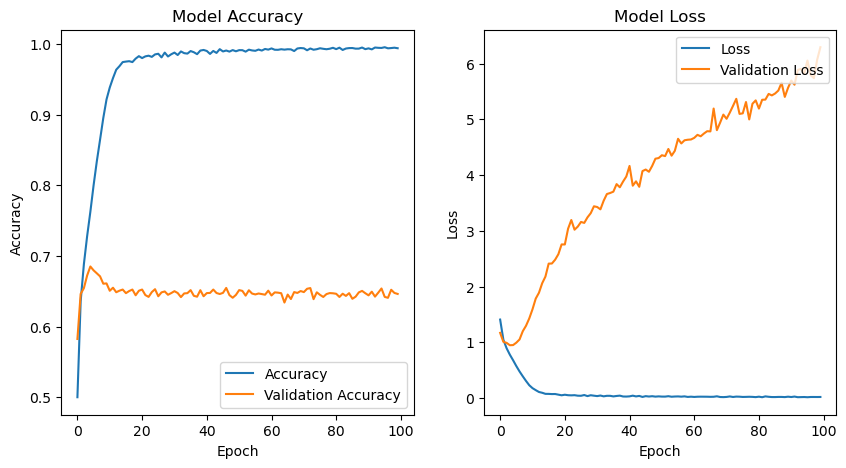

In [13]:
vgg_single_block_model_history = vgg_single_block_model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_single_block_model_history)

Evaluate the model on the test set - the expected accuracy should be much higher than the simple neural network

Test accuracy: 0.6326000094413757
Test loss: 6.392244338989258
313/313 [==============================] - 0s 1ms/step


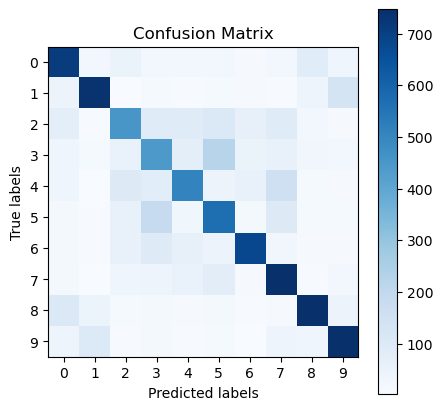

In [14]:
test_model(vgg_single_block_model)

As expected, the accuracy is higher than the simple neural network. This is reflected in the confusion matrix, where the model is much better at predicting the correct class for each image (the diagonal is much lighter than the simple neural network's confusion matrix). However, the model is rapidly overfitting the validation data set after a few epochs which may be because the model is too complex for the small dataset.

### Double VGG Block

Lets try adding another VGG block with 64 filters to the model and see how it affects the accuracy.

In [15]:
vgg_double_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_double_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 3s 4ms/step - loss: 1.5157 - accuracy: 0.4505 - val_loss: 1.2178 - val_accuracy: 0.5698
Epoch 2/100
625/625 [==============================] - 2s 4ms/step - loss: 1.0679 - accuracy: 0.6228 - val_loss: 1.0036 - val_accuracy: 0.6519
Epoch 3/100
625/625 [==============================] - 2s 4ms/step - loss: 0.8703 - accuracy: 0.6954 - val_loss: 0.9525 - val_accuracy: 0.6703
Epoch 4/100
625/625 [==============================] - 2s 4ms/step - loss: 0.7500 - accuracy: 0.7381 - val_loss: 0.8411 - val_accuracy: 0.7135
Epoch 5/100
625/625 [==============================] - 2s 4ms/step - loss: 0.6421 - accuracy: 0.7759 - val_loss: 0.8742 - val_accuracy: 0.7068
Epoch 6/100
625/625 [==============================] - 2s 4ms/step - loss: 0.5488 - accuracy: 0.8087 - val_loss: 0.9039 - val_accuracy: 0.7167
Epoch 7/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4615 - accuracy: 0.8396 - val_loss: 0.8955 - val_accuracy: 0.7133

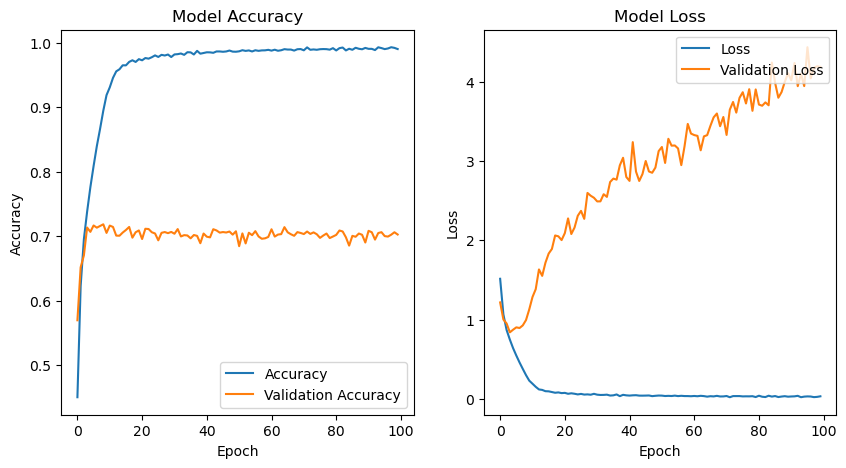

In [16]:
vgg_double_block_model_history = vgg_double_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                           validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_double_block_model_history)

Test accuracy: 0.7027000188827515
Test loss: 4.184782981872559
313/313 [==============================] - 0s 1ms/step


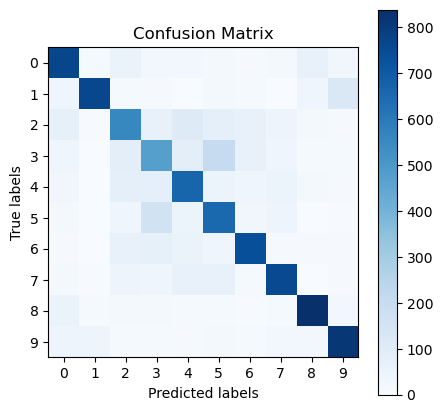

In [17]:
test_model(vgg_double_block_model)

The accuracy has improved by a reasonable amount over the single VGG block model, so it is plausible that adding another VGG block will improve the accuracy even further. This time, lets add a block with 128 filters.

### Triple VGG Block

In [18]:
vgg_triple_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    VGGBlock(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 4s 6ms/step - loss: 1.5797 - accuracy: 0.4218 - val_loss: 1.2150 - val_accuracy: 0.5632
Epoch 2/100
625/625 [==============================] - 3s 5ms/step - loss: 1.0544 - accuracy: 0.6231 - val_loss: 0.9385 - val_accuracy: 0.6688
Epoch 3/100
625/625 [==============================] - 3s 5ms/step - loss: 0.8346 - accuracy: 0.7049 - val_loss: 0.8600 - val_accuracy: 0.7017
Epoch 4/100
625/625 [==============================] - 3s 5ms/step - loss: 0.7008 - accuracy: 0.7538 - val_loss: 0.7984 - val_accuracy: 0.7298
Epoch 5/100
625/625 [==============================] - 3s 5ms/step - loss: 0.5897 - accuracy: 0.7939 - val_loss: 0.7433 - val_accuracy: 0.7503
Epoch 6/100
625/625 [==============================] - 3s 5ms/step - loss: 0.4949 - accuracy: 0.8267 - val_loss: 0.7363 - val_accuracy: 0.7446
Epoch 7/100
625/625 [==============================] - 3s 5ms/step - loss: 0.4115 - accuracy: 0.8557 - val_loss: 0.8290 - val_accuracy: 0.7370

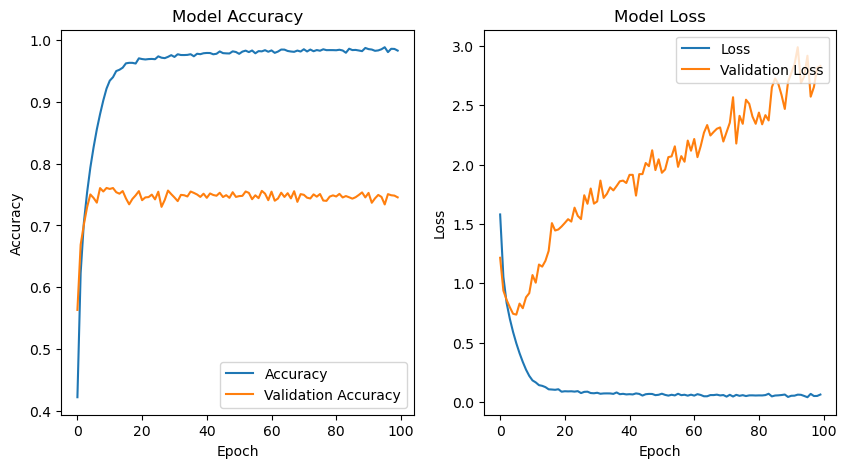

In [19]:
vgg_triple_block_model_history = vgg_triple_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                           validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_model_history)

Test accuracy: 0.7455999851226807
Test loss: 2.8297901153564453
313/313 [==============================] - 1s 2ms/step


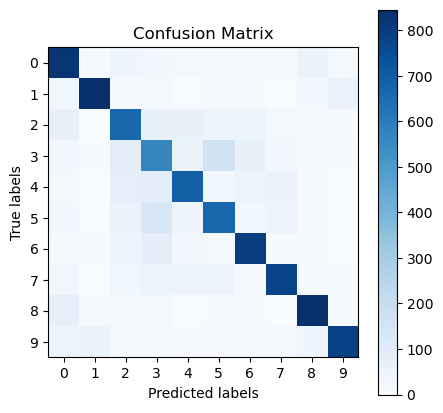

In [20]:
test_model(vgg_triple_block_model)

The accuracy has improved over the double VGG block model, but not by as much as the difference between the single and double VGG block models. It is therefore plausible that adding more VGG blocks will not necessarily improve the accuracy of the model i.e. we will reach a threshold where adding more VGG blocks will not improve the accuracy of the model, but instead just increase the training time because of the increase in the number of parameters. Like the other architectures used, we can see that all of the models were rapidly overfitting the training data after 5-10 epochs, so we can next explore different types of regularisation to prevent this.

### Model Regularisation

In each of the graphs displaying the loss of each model, the validation loss is shown to decrease for several epochs before rapidly increasing again. This signals that the model is overfitting the training data which means we need to add regularisation to the model. In this section, we will explore different types of regularisation on the triple VGG block model and compare the results.

The different types of regularisation that will be compared are: dropout regularisation, batch normalisation and data augmentation.

The first type that will be explored is dropout regularisation which is a technique where neurons are selected at random and dropped out of the network during training. This reduces the chance of overfitting by preventing the model from relying on specific neurons. Increasing the dropout rate in each VGG block will be explored to see how it affects the accuracy of the model.

In [21]:
vgg_triple_block_model_dropout = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlock(filters=64, activation='relu'),
    Dropout(0.3),
    VGGBlock(filters=128, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model_dropout.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 4s 6ms/step - loss: 1.6907 - accuracy: 0.3756 - val_loss: 1.2990 - val_accuracy: 0.5199
Epoch 2/100
625/625 [==============================] - 3s 5ms/step - loss: 1.2345 - accuracy: 0.5541 - val_loss: 1.0311 - val_accuracy: 0.6314
Epoch 3/100
625/625 [==============================] - 3s 5ms/step - loss: 1.0377 - accuracy: 0.6289 - val_loss: 0.9223 - val_accuracy: 0.6659
Epoch 4/100
625/625 [==============================] - 3s 5ms/step - loss: 0.9211 - accuracy: 0.6722 - val_loss: 0.8197 - val_accuracy: 0.7090
Epoch 5/100
625/625 [==============================] - 3s 5ms/step - loss: 0.8403 - accuracy: 0.7017 - val_loss: 0.8242 - val_accuracy: 0.7087
Epoch 6/100
625/625 [==============================] - 3s 5ms/step - loss: 0.7850 - accuracy: 0.7222 - val_loss: 0.7618 - val_accuracy: 0.7326
Epoch 7/100
625/625 [==============================] - 3s 5ms/step - loss: 0.7294 - accuracy: 0.7417 - val_loss: 0.7093 - val_accuracy: 0.7532

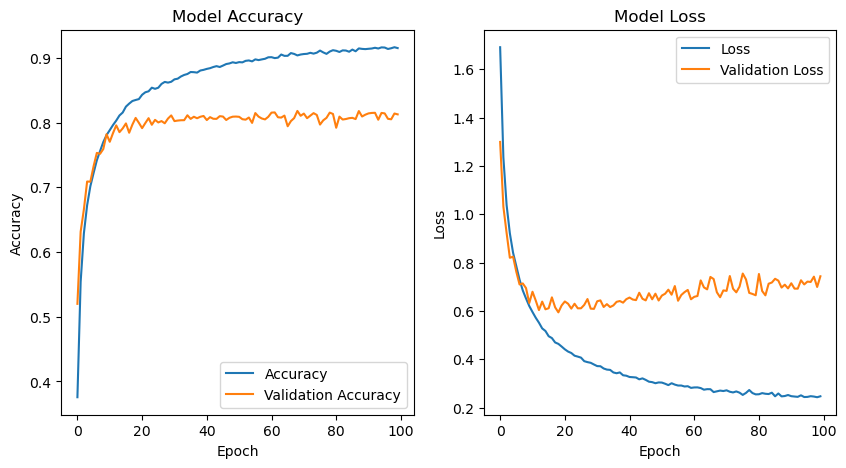

In [22]:
vgg_triple_block_model_dropout_history = vgg_triple_block_model_dropout.fit(x_train, y_train, batch_size=64, epochs=100,
                                               validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_model_dropout_history)

Test accuracy: 0.8127999901771545
Test loss: 0.7432193160057068
313/313 [==============================] - 1s 2ms/step


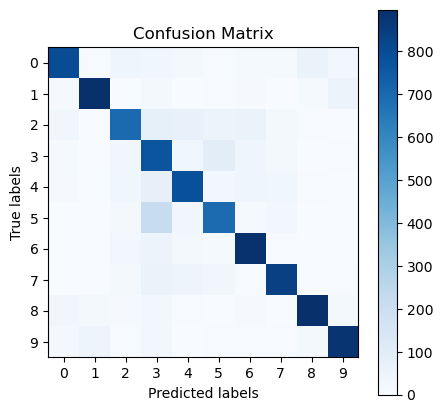

In [23]:
test_model(vgg_triple_block_model_dropout)

As can be seen from the test accuracy, regularisation via dropout has improved the performance of the model. This is also reflected in the confusion matrix, where the diagonal line is lighter than before. There is much less overfitting of the training data too because the validation loss is much lower than before.

Let's create a triple VGG block model with batch normalisation and compare the results. Batch normalisation regulates the values of the neurons in each layer by normalising it to a mean of 0 and a standard deviation of 1 which prevents overfitting by stopping a value from becoming too large or small.

In [24]:
from tensorflow.keras.layers import BatchNormalization

def VGGBlockBatchNormalisation(filters, activation, input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])
    else:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation, input_shape=input_shape),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])

In [25]:
vgg_triple_block_batch_normalisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlockBatchNormalisation(filters=64, activation='relu'),
    VGGBlockBatchNormalisation(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_batch_normalisation.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 5s 7ms/step - loss: 1.2946 - accuracy: 0.5406 - val_loss: 1.0793 - val_accuracy: 0.6113
Epoch 2/100
625/625 [==============================] - 4s 7ms/step - loss: 0.8258 - accuracy: 0.7084 - val_loss: 0.8906 - val_accuracy: 0.6968
Epoch 3/100
625/625 [==============================] - 4s 7ms/step - loss: 0.6439 - accuracy: 0.7737 - val_loss: 0.7497 - val_accuracy: 0.7429
Epoch 4/100
625/625 [==============================] - 4s 7ms/step - loss: 0.5255 - accuracy: 0.8159 - val_loss: 0.8128 - val_accuracy: 0.7297
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 0.4200 - accuracy: 0.8534 - val_loss: 0.7961 - val_accuracy: 0.7496
Epoch 6/100
625/625 [==============================] - 4s 7ms/step - loss: 0.3273 - accuracy: 0.8837 - val_loss: 0.7418 - val_accuracy: 0.7737
Epoch 7/100
625/625 [==============================] - 4s 7ms/step - loss: 0.2518 - accuracy: 0.9122 - val_loss: 0.7433 - val_accuracy: 0.7840

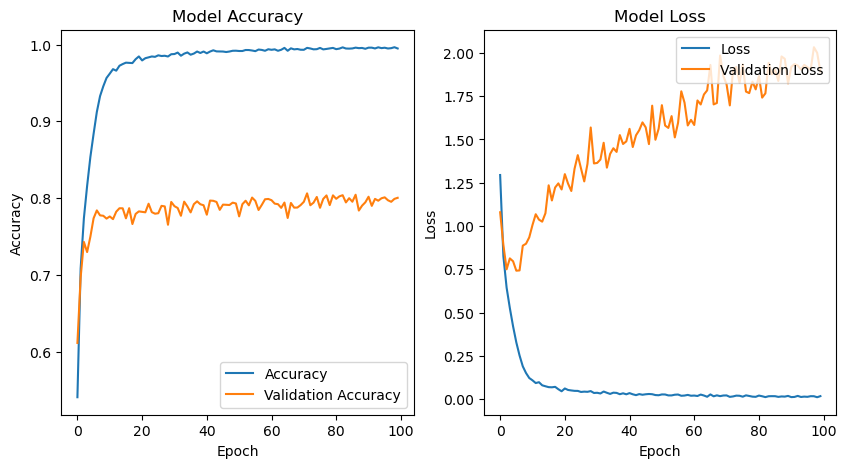

In [26]:
vgg_triple_block_batch_normalisation_history = vgg_triple_block_batch_normalisation.fit(x_train, y_train, batch_size=64, epochs=100,
                                                   validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_batch_normalisation_history)

Test accuracy: 0.8004000186920166
Test loss: 1.892259120941162
313/313 [==============================] - 1s 2ms/step


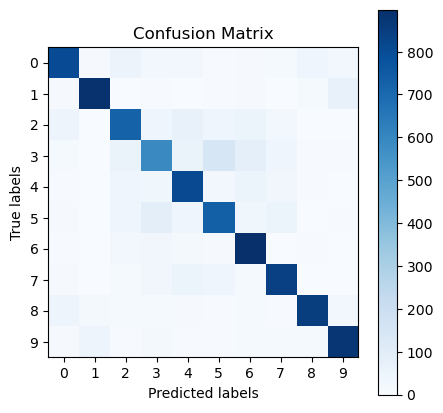

In [27]:
test_model(vgg_triple_block_batch_normalisation)

Similar to dropout regularisation, batch normalisation has improved the performance of the model as the test accuracy is higher. The level of overfitting has been reduced as the validation loss is lower than before, although it is still higher than the dropout regularisation model, therefore something that may be worth exploring later is a combination of dropout and batch normalisation.

The final type of regularisation that will be explored is data augmentation. This is a technique where the size of the training dataset is increased by applying random transformations to the images to prevent the model from overfitting the training data. The transformations that will be applied are: rotation, width shift, height shift and horizontal flip using the ImageDataGenerator class from Keras.

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object that will apply the transformations
data_generator = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

In [29]:
vgg_triple_block_data_augmentation = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    VGGBlock(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_data_augmentation.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 13s 20ms/step - loss: 1.6795 - accuracy: 0.3814 - val_loss: 1.3046 - val_accuracy: 0.5248
Epoch 2/100
625/625 [==============================] - 12s 19ms/step - loss: 1.2579 - accuracy: 0.5450 - val_loss: 1.0894 - val_accuracy: 0.6029
Epoch 3/100
625/625 [==============================] - 12s 19ms/step - loss: 1.0766 - accuracy: 0.6153 - val_loss: 1.1183 - val_accuracy: 0.6205
Epoch 4/100
625/625 [==============================] - 12s 19ms/step - loss: 0.9650 - accuracy: 0.6607 - val_loss: 0.8680 - val_accuracy: 0.7006
Epoch 5/100
625/625 [==============================] - 12s 20ms/step - loss: 0.8816 - accuracy: 0.6906 - val_loss: 0.8498 - val_accuracy: 0.7108
Epoch 6/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8115 - accuracy: 0.7140 - val_loss: 0.7904 - val_accuracy: 0.7241
Epoch 7/100
625/625 [==============================] - 12s 19ms/step - loss: 0.7679 - accuracy: 0.7283 - val_loss: 0.7600 - val_ac

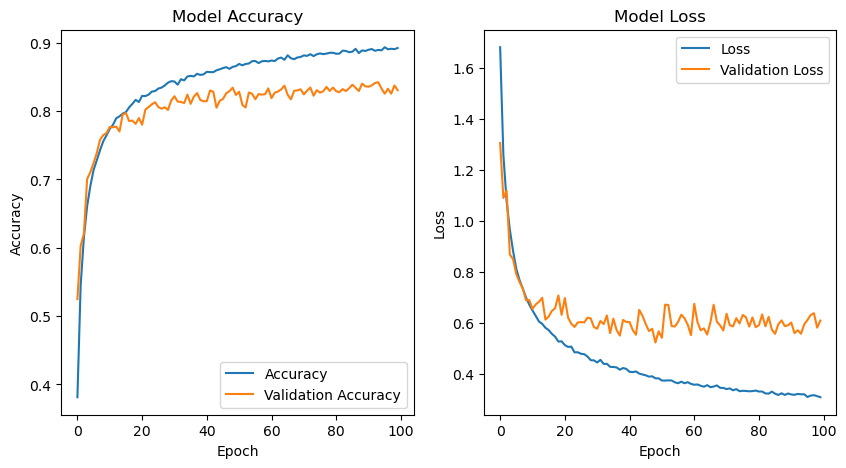

In [30]:
vgg_triple_block_data_augmentation_history = vgg_triple_block_data_augmentation.fit(data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
                                                 validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_data_augmentation_history)

Test accuracy: 0.8306999802589417
Test loss: 0.6092864871025085
313/313 [==============================] - 1s 2ms/step


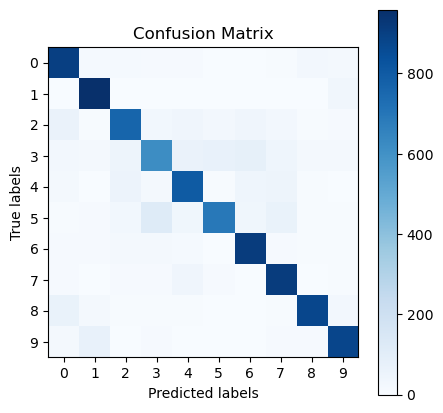

In [31]:
test_model(vgg_triple_block_data_augmentation)

Data augmentation has also improved the performance of the model. The level of overfitting has been reduced as the validation loss doesn't consistently increase as the training loss decreases.

Since all three types of regularisation have improved the performance of the model, it is worth exploring a model that uses all three types of regularisation.

In [32]:
vgg_triple_block_all_regularisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlockBatchNormalisation(filters=64, activation='relu'),
    Dropout(0.3),
    VGGBlockBatchNormalisation(filters=128, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_all_regularisation.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 13s 20ms/step - loss: 1.5979 - accuracy: 0.4222 - val_loss: 1.2588 - val_accuracy: 0.5440
Epoch 2/100
625/625 [==============================] - 12s 19ms/step - loss: 1.2340 - accuracy: 0.5548 - val_loss: 1.1318 - val_accuracy: 0.6090
Epoch 3/100
625/625 [==============================] - 12s 20ms/step - loss: 1.0655 - accuracy: 0.6207 - val_loss: 1.2142 - val_accuracy: 0.6078
Epoch 4/100
625/625 [==============================] - 12s 20ms/step - loss: 0.9665 - accuracy: 0.6589 - val_loss: 0.8873 - val_accuracy: 0.6920
Epoch 5/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8956 - accuracy: 0.6842 - val_loss: 0.8449 - val_accuracy: 0.7115
Epoch 6/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8464 - accuracy: 0.7034 - val_loss: 0.8268 - val_accuracy: 0.7204
Epoch 7/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8076 - accuracy: 0.7189 - val_loss: 0.8270 - val_ac

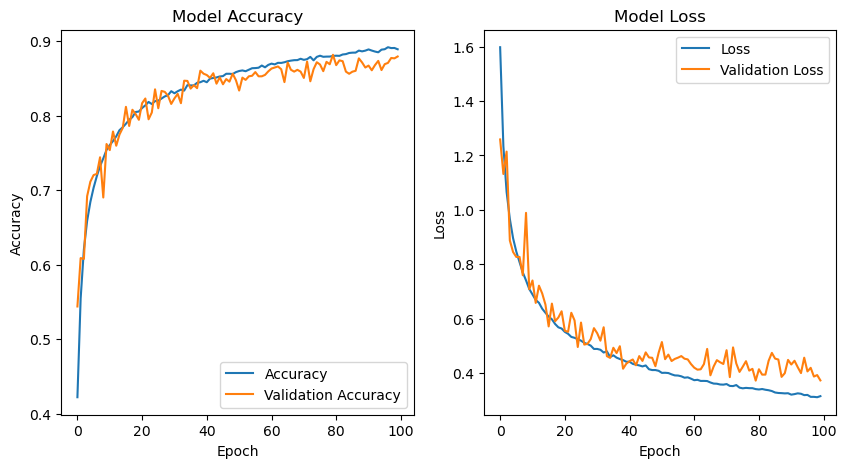

In [33]:
vgg_triple_block_all_regularisation_history = vgg_triple_block_all_regularisation.fit(data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
                                                 validation_data=(x_val, y_val))
plot_training_accuracy_loss(vgg_triple_block_all_regularisation_history)


Test accuracy: 0.8795999884605408
Test loss: 0.3729267120361328
313/313 [==============================] - 1s 2ms/step


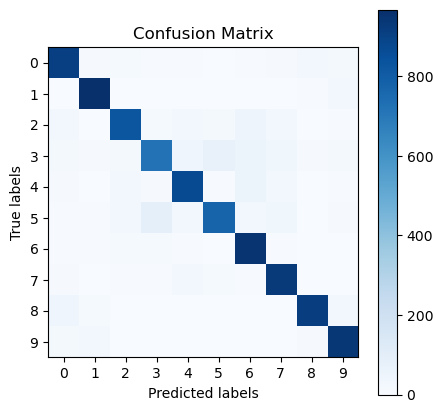

In [34]:
test_model(vgg_triple_block_all_regularisation)

As can be seen from the training and validation loss graph, this model is no longer overfitting the training data due to the combination of several regularisation techniques. The test accuracy is also higher than the other models, as reflected in the confusion matrix.

## Conclusion

In [82]:
def plot_accuracy_history(**kwargs):
    plt.figure(figsize=(8, 6))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (name, history) in enumerate(kwargs.items()):
        color = colours[i % len(colours)]
        plt.plot(history.history['accuracy'], label=f"{name} train", color=color)
        plt.plot(history.history['val_accuracy'], label=f"{name} validation", color=color, linestyle='--')

    plt.title('VGG Block Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss_history(**kwargs):
    plt.figure(figsize=(8, 6))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (name, history) in enumerate(kwargs.items()):
        color = colours[i % len(colours)]
        plt.plot(history.history['loss'], label=f"{name} train", color=color)
        plt.plot(history.history['val_loss'], label=f"{name} validation", color=color, linestyle='--')

    plt.title('VGG Block Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### VGG Block Comparison

First, create a graph to compare the performance of single, double and triple VGG blocks.

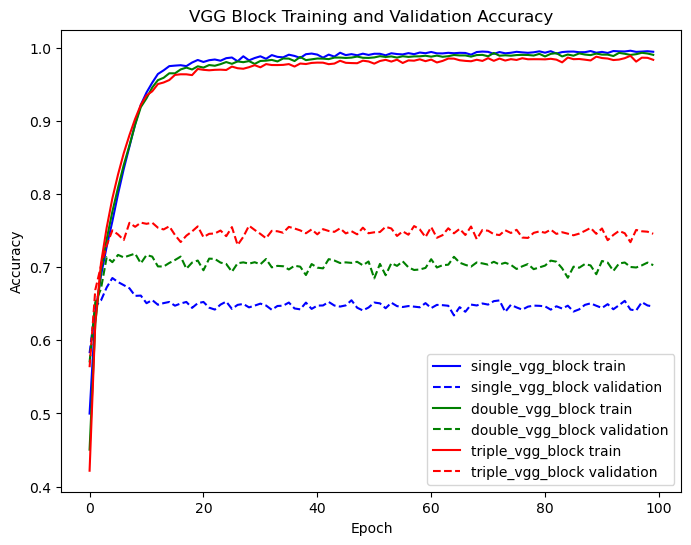

In [80]:
plot_accuracy_history(single_vgg_block=vgg_single_block_model_history, double_vgg_block=vgg_double_block_model_history, triple_vgg_block=vgg_triple_block_model_history)

As can be seen from the graph, the triple VGG block model has higher accuracy than the single and double block models. This may be because the triple VGG block model has more parameters so it's able to learn more complex features from the training data. As mentioned previously, the difference in validation accuracy between the single and double block models is larger than the difference between the double and triple block models which suggests that continuing to add more and more VGG blocks won't necessarily improve the performance of the model.

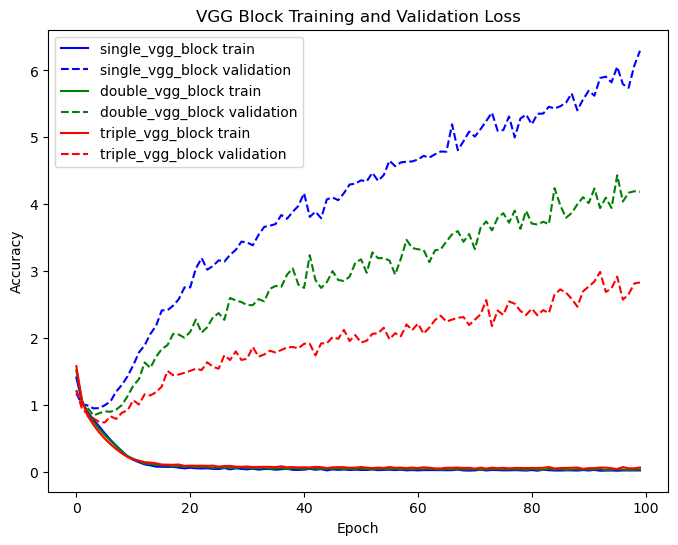

In [83]:
plot_loss_history(single_vgg_block=vgg_single_block_model_history, double_vgg_block=vgg_double_block_model_history, triple_vgg_block=vgg_triple_block_model_history)

### VGG Regularisation Comparison

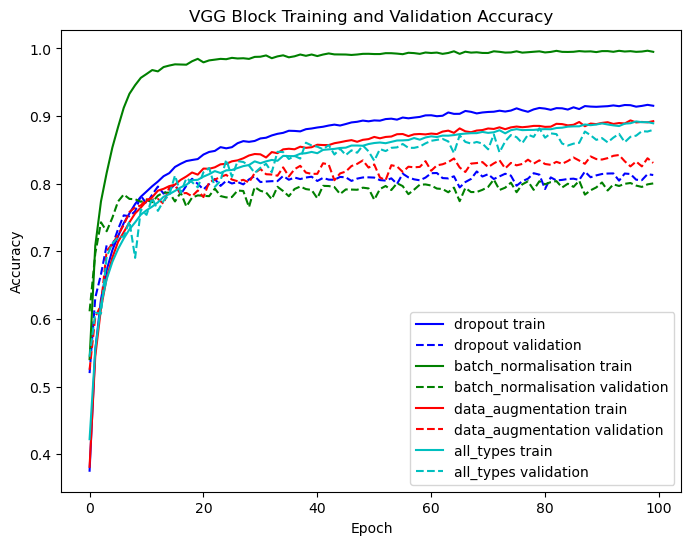

In [81]:
plot_accuracy_history(dropout=vgg_triple_block_model_dropout_history, batch_normalisation=vgg_triple_block_batch_normalisation_history, data_augmentation=vgg_triple_block_data_augmentation_history, all_types=vgg_triple_block_all_regularisation_history)

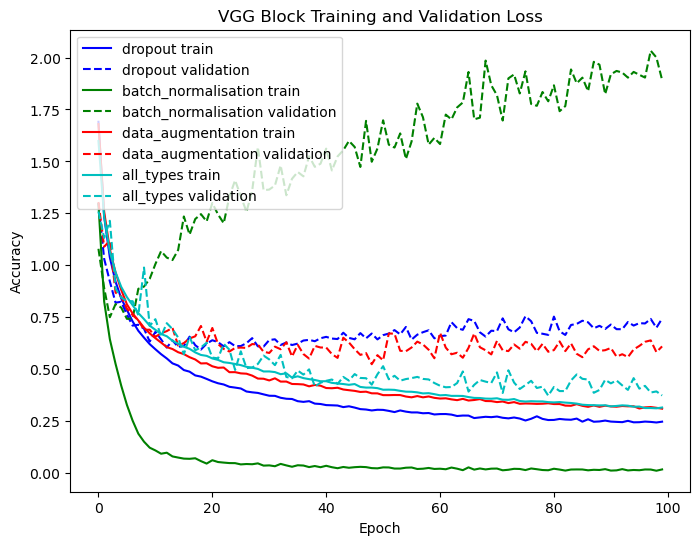

In [84]:
plot_loss_history(dropout=vgg_triple_block_model_dropout_history, batch_normalisation=vgg_triple_block_batch_normalisation_history, data_augmentation=vgg_triple_block_data_augmentation_history, all_types=vgg_triple_block_all_regularisation_history)

Test accuracy: 0.7455999851226807
Test loss: 2.8297901153564453
313/313 [==============================] - 1s 2ms/step


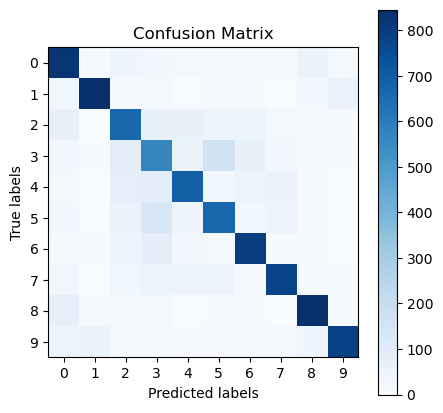

Test accuracy: 0.8795999884605408
Test loss: 0.3729267120361328
313/313 [==============================] - 1s 2ms/step


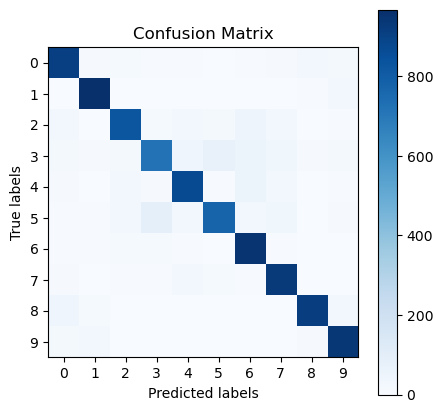

In [78]:
test_model(vgg_triple_block_model)
test_model(vgg_triple_block_all_regularisation)